In [6]:
# This file is part of pydidas.
#
# Copyright 2023 - 2024, Helmholtz-Zentrum Hereon
# SPDX-License-Identifier: GPL-3.0-only
#
# pydidas is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License version 3 as
# published by the Free Software Foundation.
#
# Pydidas is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Pydidas. If not, see <http://www.gnu.org/licenses/>.

"""
The dataset module includes the Dataset subclasses of numpy.ndarray with additional
embedded metadata.
"""

__author__ = "Gudrun Lotze"
__copyright__ = "Copyright 2024, Helmholtz-Zentrum Hereon"
__license__ = "GPL-3.0-only"
__maintainer__ = "Gudrun Lotze"
__status__ = "Development"

In [7]:
import os
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from pydidas.core import Dataset
from pydidas.data_io import import_data
%matplotlib inline


import importlib
import sys

fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/stress_strain.py'
spec = importlib.util.spec_from_file_location('stress_strain', fname)
stress_strain = importlib.util.module_from_spec(spec)
spec.loader.exec_module(stress_strain)

# Check if the module object is created
if hasattr(stress_strain, '__file__'):
    print("Module was successfully loaded.")

# Inspect module attributes
print("Module attributes:", dir(stress_strain))

#We need to append the path to the sys.path to import the module
sys.path.append('/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins')

from  stress_strain import extract_d_spacing, chi_pos_verification, extract_d_spacing, ds_slicing, combine_sort_d_spacing_pos_neg, group_d_spacing_by_chi, extract_units, get_param_unit_at_index, idx_s2c_grouping, pre_regression_calculation


import pydidas 
print('Pydidas version: ', pydidas.version)

Module was successfully loaded.
Module attributes: ['Dataset', '__author__', '__builtins__', '__cached__', '__copyright__', '__doc__', '__file__', '__license__', '__loader__', '__maintainer__', '__name__', '__package__', '__spec__', '__status__', 'chi_pos_unit_verification', 'chi_pos_verification', 'combine_sort_d_spacing_pos_neg', 'connected_components', 'csr_matrix', 'ds_slicing', 'extract_d_spacing', 'extract_units', 'get_param_unit_at_index', 'group_d_spacing_by_chi', 'h5', 'idx_s2c_grouping', 'import_data', 'np', 'os', 'pre_regression_calculation']
Pydidas version:  24.06.05


Auxiliary functions

Chi
 [-90 -80 -70 -60 -50 -40 -30 -20 -10   0]
Result array spatial shape
 (6, 5, 10, 5)
🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿
Dataset(
axis_labels: {
    0: 'y'
    1: 'x'
    2: 'chi'
    3: '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count
       intensity'},
axis_ranges: {
    0: array([2, 3, 4, 5, 6, 7])
    1: array([0, 1, 2, 3, 4])
    2: array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0])
    3: array([0, 1, 2, 3, 4])},
axis_units: {
    0: 'um'
    1: 'um'
    2: 'deg'
    3: ''},
metadata: {},
data_unit: ,
data_label: position / nm; area / (cts * nm^-1); FWHM / nm^-1;background at peak / cts; total count intensity / cts,
array([[[[ 25.033128,  12.191281, ...,   5.109282, 316.533877],
         [ 25.00854 ,  29.179443, ...,   4.314869, 786.082564],
         ...,
         [ 25.2124  ,  25.338603, ...,   4.727045, 127.307931],
         [ 25.250072,  21.412728, ...,   4.688131, 436.505139]],

        [[ 25.043128,   7.028834, ...,   2.914339, 261.22443

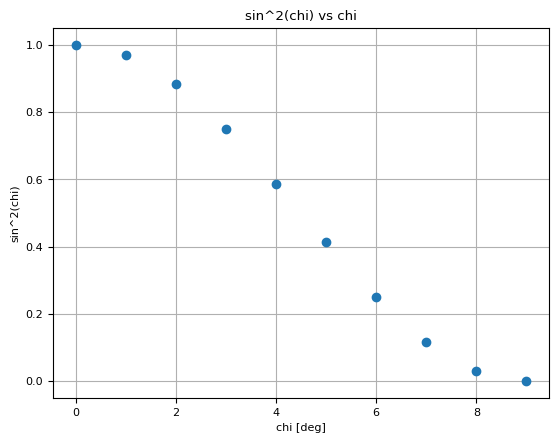

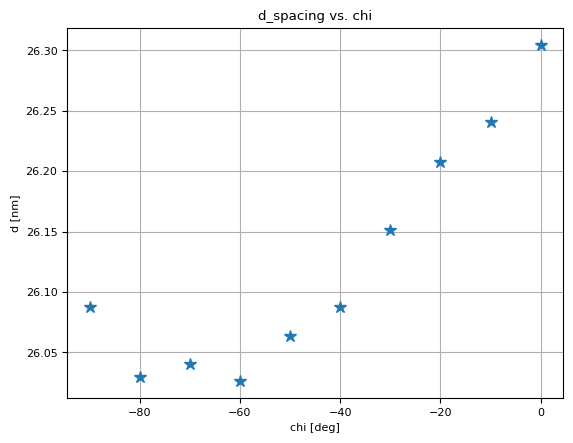

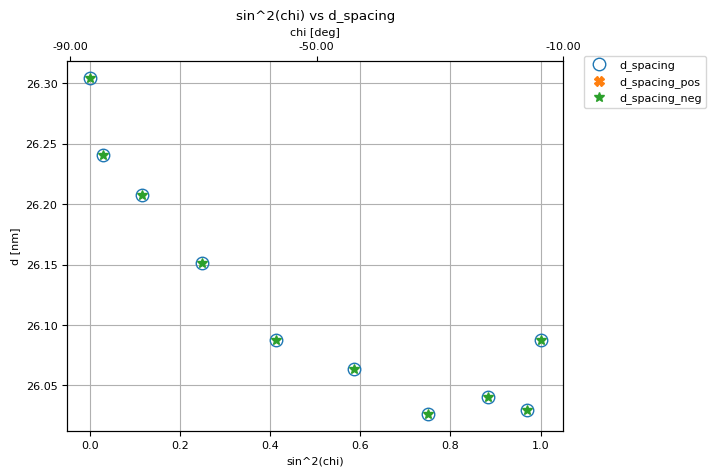

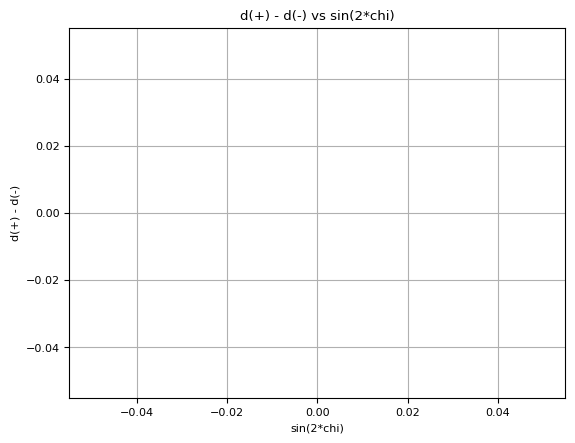

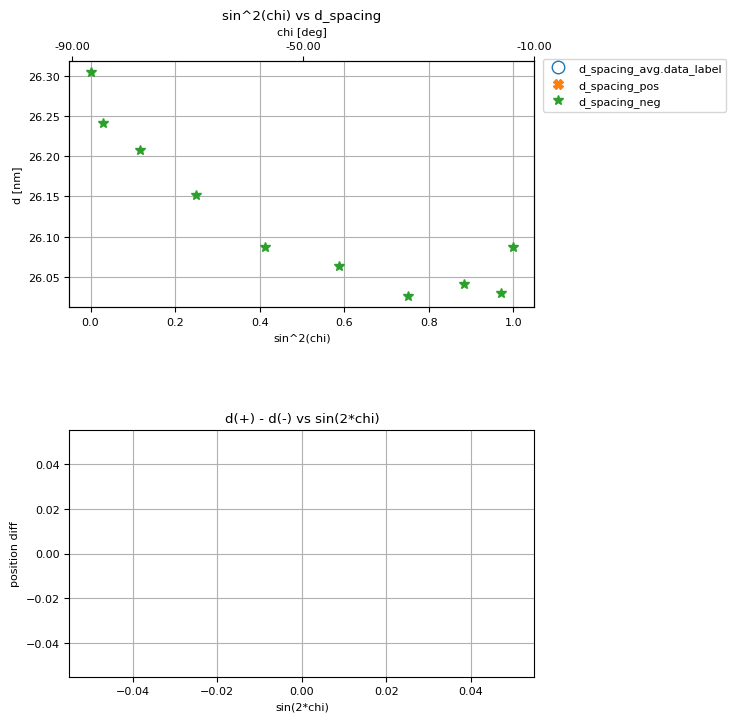

In [8]:
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def plot_sin2chi(chi):
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, linestyle='None', marker='o')
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs chi')
    ax.grid()
    fig.show()

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  


def plot_d_spacing_vs_chi(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """

    print('ds.shape:', ds.shape)
    
    fig, ax = plt.subplots()
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs chi for various x,y')
    ax.grid(True)
    
    ax.legend()
    plt.show()
    

    

def main():
    
    #Creating of dummy data
    delta_chi =10
    chi_start= -90
    chi_stop= 1
    phase_shift = 70
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
    
    plot_sin2chi(chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #data_labels= 'position / nm^-1; area / (cts * nm^-1); FWHM / nm^-1;background at peak / cts; total count intensity / cts'
    #make up data label for position
    data_labels= 'position / nm; area / (cts * nm^-1); FWHM / nm^-1;background at peak / cts; total count intensity / cts'
    
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
   
    result_array_spatial = generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=True, phase_shift=phase_shift)
    #result_array = generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=False)
    print('Result array spatial shape\n', result_array_spatial.shape)
    

    ds = Dataset(result_array_spatial,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
    #ds_no_spatial = Dataset(result_array,  axis_labels=axis_labels, axis_ranges=axis_ranges)
    
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
   
   
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
    
    
    #visualisation
    #positions = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
    #plot_d_spacing_vs_chi(ds, chi, positions)
    #plot_d_spacing_vs_chi(ds_no_spatial, chi, positions)
      
    #choose random location in ds
    x_idx = 5
    y_idx = 3
    
    #plot_d_spacing_vs_chi(ds, chi, [(x_idx, y_idx)])
    
    
    # slice Dataset based on location
    ds1 = ds[x_idx, y_idx]
    print('Content of ds1 before noise addition\n', ds1.array[:,0])
          
    #Introducing seed and random noise for d_spacing
    ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
    #print('Shape of ds1 dataset\n', ds1.shape)
    #print('Content ds1 array after noise addition\n',  ds1.array[:,0])
    #print(ds1)
    
    
    #Introducing np.nan 
    #print('Content ds1 array',  ds1.array[:,0])
    #ds1.array[0:9:2,0] = np.nan
    #ds1.array[18:28:2,0] = np.nan
   
    fig, ax = plt.subplots()
    ax.plot(chi, ds1.array[:,0], linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.grid()
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('chi [deg]')
    ax.set_title('d_spacing vs. chi')
    fig.show()
          
    chi_key, (pos_key, pos_idx) = chi_pos_verification(ds1)
    print('chi_key, pos_key, pos_idx:')
    print(chi_key, pos_key, pos_idx)

    chi, d_spacing = ds_slicing(ds1)    
    
    print(40*"\N{microbe}")
    print(d_spacing)
    print(40*"\N{microbe}")
    
        
    d_spacing_pos, d_spacing_neg=group_d_spacing_by_chi(d_spacing, chi)
    
    print(40*"\N{Cherries}")
    print('d_spacing_pos\n',d_spacing_pos)
    print(40*"\N{palm tree}")
    print('d_spacing_neg\n',d_spacing_neg)
    print(40*"\N{Cherries}")
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs d_spacing')
    interval = 4
    x_index = np.arange(0, len(chi), interval)
    ax2top=ax.twiny()
    ax2top.set_xlim(ax.get_xlim())
    formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    ax2top.set_xticks(x_index)
    ax2top.set_xticklabels(formatted_labels)
    ax2top.set_xlabel('chi [deg]')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
    ax.grid()
    fig.show()
    
      
    
    print('s2c_pos', d_spacing_pos.axis_ranges[0])
    print('d_spacing_pos', d_spacing_pos.array)
    print('s2c_neg', d_spacing_neg.axis_ranges[0])
    print('d_spacing_neg', d_spacing_neg.array)
    
    d_spacing_combined = combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    #print('d_spacing_combined, shape', d_spacing_combined.shape)
    print('d_spacing_combined', d_spacing_combined) 
        
    d_diff= np.diff(d_spacing_combined.array, axis=0).squeeze()
    x_diff = np.sin(2*np.arcsin(np.sqrt(d_spacing_combined.axis_ranges[1])))
    
    print('d_diff', d_diff)
    print('x_diff', x_diff)
    print(d_spacing_combined.axis_ranges[1])
    
    fig, ax = plt.subplots()
    ax.plot(x_diff, d_diff, linestyle='None', marker='o')
    ax.set_title('d(+) - d(-) vs sin(2*chi)')
    ax.set_xlabel('sin(2*chi)')
    ax.set_ylabel('d(+) - d(-)')
    ax.grid()
    fig.show()
    
    
    ds2 = ds1.copy()
    print(ds2)
    print(ds2+2)
    
      
    def plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff):
        import matplotlib.gridspec as gridspec
        # Create a GridSpec with explicit height ratios
        fig = plt.figure(figsize=(6, 8))  # Adjust figure size as needed
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.5)  # Increase hspace for more vertical space
    
        # Create the subplots using ax[0] and ax[1]
        ax = [None, None]
        ax[0] = fig.add_subplot(gs[0])
        ax[1] = fig.add_subplot(gs[1])
        
        ax[0].plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label='d_spacing_avg.data_label', markerfacecolor='None', markersize=9)
        ax[0].plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
        ax[0].plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
        ax[0].set_ylabel('d [nm]')
        ax[0].set_xlabel(d_spacing_avg.axis_labels[0])
        ax[0].set_title('sin^2(chi) vs d_spacing')
        interval = 4
        x_index = np.arange(0, len(chi), interval)
        ax2top=ax[0].twiny()
        ax2top.set_xlim(ax[0].get_xlim())
        formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
        ax2top.set_xticks(x_index)
        ax2top.set_xticklabels(formatted_labels)
        ax2top.set_xlabel('chi [deg]')
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.425, 1.03))
        
        ax[0].grid()
        
        ax[1].plot(d_spacing_diff.axis_ranges[0], d_spacing_diff.array, linestyle='None', marker='o', label=d_spacing_diff.data_label, markersize=9)
        ax[1].set_title('d(+) - d(-) vs sin(2*chi)')
        ax[1].set_xlabel(d_spacing_diff.axis_labels[0])
        ax[1].set_ylabel(d_spacing_diff.data_label)
        ax[1].grid()
        # Adjust the space between the subplots
        fig.subplots_adjust(hspace=0.2)  # Adjust the vertical space    
        fig.show() 
        
    d_spacing_avg, d_spacing_diff = pre_regression_calculation(d_spacing_combined) 
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff)
                
        

if __name__ == "__main__":
    main()

In [9]:
import sys
sys.platform
sys.path

['/Users/lotzegud/miniforge3/envs/pydidas_dev/lib/python311.zip',
 '/Users/lotzegud/miniforge3/envs/pydidas_dev/lib/python3.11',
 '/Users/lotzegud/miniforge3/envs/pydidas_dev/lib/python3.11/lib-dynload',
 '',
 '/Users/lotzegud/miniforge3/envs/pydidas_dev/lib/python3.11/site-packages',
 '/Users/lotzegud/pydidas',
 '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins',
 '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins']

In [10]:
import pydidas
print(pydidas)
print(pydidas.version)
print(pydidas.__version__)

<module 'pydidas' from '/Users/lotzegud/pydidas/pydidas/__init__.py'>
24.06.05


AttributeError: module 'pydidas' has no attribute '__version__'

In [ ]:
import os
from pydidas.data_io.import_export import import_data

fname='/Users/lotzegud/pydidas_training/Peak_1_2/node_03_peak_1.h5'
ds= import_data(fname)
print(ds)
#overwrite data label
#ds.data_label='position / nm^-1; area / (cts * nm^-1); FWHM / nm^-1; background at peak / cts; total count intensity / cts'
print(ds)

#fname2= '/Users/lotzegud/pydidas_training/Peak_1_2_Pydidas_v24_6_5/node_03_peak_1.h5'
#ds2= import_data(fname2)
#print(ds2)

extract_units(ds)



In [ ]:
ds_units = extract_units(ds)
print('ds_units:', ds_units)
chi_key, (pos_key, pos_idx) = chi_pos_verification(ds)
print('chi_key', chi_key, 'pos_key',  pos_key, 'pos_idx', pos_idx)
key_at_pos_idx, unit_at_pos_idx= get_param_unit_at_index(ds_units, pos_idx)

print('key_at_pos_idx:', key_at_pos_idx, 'unit_at_pos_idx:', unit_at_pos_idx)


In [ ]:
ds.update_axis_label(3,'5: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity')
chi_key, (pos_key, pos_idx) = chi_pos_verification(ds)
print('chi_key', chi_key, 'pos_key',  pos_key, 'pos_idx', pos_idx)



ds_slicing(ds)

In [ ]:
ones_array = np.ones((3, 2, 1, 5))
# Create the arange array and reshape it to (1, 1, 1, 5)
arange_array = np.arange(5).reshape(1, 1, 1, 5)
# Multiply using broadcasting
result_array = ones_array * arange_array

axis_units=['um', 'um', 'deg', '']
data_label='area / (cts * nm); FWHM / nm; background at peak / cts; total count intensity / cts; position / nm' 
axis_labels= ['y', 'x', 'chi', 'fit_labels']
fit_labels= '1: area; 2: FWHM; 3: background at peak; 4: total count intensity; 5: position'
ds2=Dataset(result_array, axis_labels=axis_labels,data_label=data_label, axis_units=axis_units)
ds2.update_axis_label(3,fit_labels)
print(ds2)

print('ds2_units:', extract_units(ds2))


chi_key, (pos_key, pos_idx) = chi_pos_verification(ds2)
print('chi_key', chi_key, 'pos_key',  pos_key, 'pos_idx', pos_idx)
print('ds2.ndim:', ds2.ndim, range(ds2.ndim))

slice1 = slice(None, None, None)
slice2 = slice(None, None, None)
slice3 = slice(None, None, None)
slice4 = slice(5, 6, None)
a=ds2[slice1, slice2, slice3, slice4]
print('here', a, a.shape)

ds_slicing(ds2)

In [ ]:
from pydidas.core import Dataset

ds2=Dataset(np.ones((2,10)), axis_labels=['y', 'x'], axis_units=['um', 'um'] , data_label='0: d- ; 1: d+')
print(ds2)
print(30*"\N{hot pepper}")
ds3=ds2.mean(axis=0)
print(id(ds3), id(ds2))
print(ds3)
print(30*"\N{popcorn}")
ds4=ds2.sum(axis=0)
print(ds4)
print(30*"\N{hot pepper}")



In [ ]:
a= np.array([[1,2,3],[5,6,7]])

b=a.mean(axis=0)
print(b)

d_spacing_combined=Dataset(np.array([[1,2,3], [5,6,7]]), axis_units={0: 'um', 1: ''}, data_label=f'0: position_neg ; 1: position_pos', data_unit= 'nm', axis_labels={0: '', 1: 'sin^2(chi)'})

In [ ]:
Dataset.argsort??
#np.argsort??

Docstring:
a.argsort(axis=-1, kind=None, order=None)

Returns the indices that would sort this array.

Refer to `numpy.argsort` for full documentation.

See Also
--------
numpy.argsort : equivalent function
Type:      method_descriptor

### Test for Dataset and sorting
- xarray uses sortby
- sortby("y"):
Directly sorts the DataArray by the coordinate values of the specified dimension.
Automatically handles both data and coordinates.
Easier for direct sorting tasks where you specify a dimension to sort by.

- argsort(axis=1):
Returns the indices that would sort the data along the specified axis.
Does not change the data or coordinates directly.
Requires you to manually use these indices to sort the data and update coordinates.

In [ ]:
#Test for sorting
#Data values
arr1= np.array([1, 2, 3, 4, 5])
#Axis values
arr2= np.array([5, 4, 3, 2, 1])/10

# Create a Dataset
ds_test=Dataset(arr1, axis_units={0: 'um'}, data_label='position', data_unit='nm', axis_labels={0: 'x'}, axis_ranges={0: arr2})
print('Dataset unsorted\n', ds_test)
print(30*'\N{microbe}')
s2c_axis= ds_test.axis_ranges[0]
sorted_idx= np.argsort(s2c_axis, kind='mergesort')
#Unsorted axis values
print(s2c_axis)
#Index of sorted axis values
print(sorted_idx)
#Sorted axis values
print(s2c_axis[sorted_idx])
print(30*'\N{palm tree}')
#Idea: Sort the data array based on the sorted index
ds_test_sorted=ds_test[sorted_idx] #sorts the data array, but not the axis_ranges
print('Dataset sorted\n', ds_test_sorted)
print(30*'\N{palm tree}')
ds_test_sorted.argsort(axis=0, kind='mergesort')
print('Another approach for sorting the dataset\n', ds_test_sorted)


Dataset unsorted
 Dataset(
axis_labels: {
    0: 'x'},
axis_ranges: {
    0: array([0.5, 0.4, 0.3, 0.2, 0.1])},
axis_units: {
    0: 'um'},
metadata: {},
data_unit: nm,
data_label: position,
array([1, 2, 3, 4, 5])
)
🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠
[0.5 0.4 0.3 0.2 0.1]
[4 3 2 1 0]
[0.1 0.2 0.3 0.4 0.5]
🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴
Dataset sorted
 Dataset(
axis_labels: {
    0: 'x'},
axis_ranges: {
    0: array([0.5, 0.4, 0.3, 0.2, 0.1])},
axis_units: {
    0: 'um'},
metadata: {},
data_unit: nm,
data_label: position,
array([5, 4, 3, 2, 1])
)
🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴🌴
Another approach for sorting the dataset
 Dataset(
axis_labels: {
    0: 'x'},
axis_ranges: {
    0: array([0.5, 0.4, 0.3, 0.2, 0.1])},
axis_units: {
    0: 'um'},
metadata: {},
data_unit: nm,
data_label: position,
array([5, 4, 3, 2, 1])
)


In [11]:
import numpy as np
from pydidas.core import Dataset  # Replace with the actual import if different

# Define the sort_by_axis function
def sort_by_axis(self, axis):
    """
    Sorts the Dataset along a specified axis and updates the axis_ranges for that axis.

    Parameters:
    - axis (int): The axis along which to sort the data.

    Returns:
    - Dataset: A new Dataset object with sorted data and updated axis_ranges.
    """
    # Ensure the axis parameter is within bounds
    if axis < 0 or axis >= self.ndim:
        raise ValueError(f"Axis {axis} is out of bounds for array with {self.ndim} dimensions")
    
    # Get the sorted indices for the specified axis
    sorted_idx = np.argsort(self.axis_ranges[axis], kind='mergesort')
    
    # Sort the data array along the specified axis using the sorted indices
    sorted_data = np.take(self, sorted_idx, axis=axis)
    
    # Sort the axis range for the specified axis
    sorted_axis_ranges = {key: (val[sorted_idx] if key == axis else val) for key, val in self.axis_ranges.items()}
    
    # Create and return a new Dataset with sorted data and axis ranges
    return Dataset(sorted_data, 
                   axis_units=self.axis_units, 
                   data_label=self.data_label, 
                   data_unit=self.data_unit, 
                   axis_labels=self.axis_labels, 
                   axis_ranges=sorted_axis_ranges)

# Add the sort_by_axis method to the Dataset class
setattr(Dataset, "sort_by_axis", sort_by_axis)

# Test for 1D and 2D sorting
# 1D Test
arr1 = np.array([1, 2, 3, 4, 5])
arr2 = np.array([5, 4, 3, 2, 1]) / 10
ds_test = Dataset(arr1, axis_units={0: 'um'}, data_label='position', data_unit='nm', axis_labels={0: 'x'}, axis_ranges={0: arr2})
print('Dataset unsorted\n', ds_test)
print(30 * '\N{microbe}')
ds_test_sorted = ds_test.sort_by_axis(0)
print('Dataset sorted\n', ds_test_sorted)

# 2D Test
arr2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr2d_axis0 = np.array([3, 2, 1])
arr2d_axis1 = np.array([1, 2, 3])
ds_test_2d = Dataset(arr2d, axis_units={0: 'x', 1: 'y'}, data_label='position', data_unit='nm', axis_labels={0: 'x', 1: 'y'}, axis_ranges={0: arr2d_axis0, 1: arr2d_axis1})
print(30 * '\N{Carrot}')
print('ds_test_2d', ds_test_2d)
print(30 * '\N{Carrot}')

# Sort the dataset by axis 0
ds_test_sorted_axis0 = ds_test_2d.sort_by_axis(0)
print('Dataset sorted by axis 0\n', ds_test_sorted_axis0)

# Sort the dataset by axis 1
ds_test_sorted_axis1 = ds_test_2d.sort_by_axis(1)
print('Dataset sorted by axis 1\n', ds_test_sorted_axis1)



Dataset unsorted
 Dataset(
axis_labels: {
    0: 'x'},
axis_ranges: {
    0: array([0.5, 0.4, 0.3, 0.2, 0.1])},
axis_units: {
    0: 'um'},
metadata: {},
data_unit: nm,
data_label: position,
array([1, 2, 3, 4, 5])
)
🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠🦠
Dataset sorted
 Dataset(
axis_labels: {
    0: 'x'},
axis_ranges: {
    0: array([0.1, 0.2, 0.3, 0.4, 0.5])},
axis_units: {
    0: 'um'},
metadata: {},
data_unit: nm,
data_label: position,
array([5, 4, 3, 2, 1])
)
🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕
ds_test_2d Dataset(
axis_labels: {
    0: 'x'
    1: 'y'},
axis_ranges: {
    0: array([3, 2, 1])
    1: array([1, 2, 3])},
axis_units: {
    0: 'x'
    1: 'y'},
metadata: {},
data_unit: nm,
data_label: position,
array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])
)
🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕🥕
Dataset sorted by axis 0
 Dataset(
axis_labels: {
    0: 'x'
    1: 'y'},
axis_ranges: {
    0: array([1, 2, 3])
    1: array([1, 2, 3])},
axis_units: {
    0: 'x'
    1: 'y'},
metadata: {},
data_unit: nm,
d

In [12]:
import xarray as xr
import numpy as np

# Create a sample DataArray
data = xr.DataArray(
    np.array([[4, 2, 3], [1, 5, 6]]),
    dims=["x", "y"],
    coords={"x": ["a", "b"], "y": [3, 2, 1]}
)

print("Original DataArray:")
print(data)

# Sort the DataArray by the 'y' coordinates
sorted_data = data.sortby('y')

print("\nDataArray sorted along 'y':")
print(sorted_data)

Original DataArray:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[4, 2, 3],
       [1, 5, 6]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 3 2 1

DataArray sorted along 'y':
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[3, 2, 4],
       [6, 5, 1]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 1 2 3


In [16]:
import xarray as xr
import numpy as np

# Create a sample DataArray
data = xr.DataArray(
    np.array([[4, 2, 3], [1, 5, 6]]),
    dims=["x", "y"],
    coords={"x": ["a", "b"], "y": [3, 2, 1]}
)

print("Original DataArray:")
print(data)

# Get the indices that would sort the DataArray along 'y'
sorted_indices = data.argsort(axis=1)
print("\nSorted indices along 'y':")
print(sorted_indices)


# Use these indices to sort the data array
sorted_data = xr.DataArray(
    np.take_along_axis(data.values, sorted_indices, axis=1),
    dims=data.dims,
    coords={"x": data.coords["x"], "y": np.sort(data.coords["y"])}
)

print("\nDataArray sorted along 'y' with argsort:")
print(sorted_data)

print('using sortby method')
print(data.sortby('y'))




Original DataArray:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[4, 2, 3],
       [1, 5, 6]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 3 2 1

Sorted indices along 'y':
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[1, 2, 0],
       [0, 1, 2]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 3 2 1

DataArray sorted along 'y' with argsort:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[2, 3, 4],
       [1, 5, 6]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 1 2 3
using sortby method
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[3, 2, 4],
       [6, 5, 1]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 1 2 3


In [15]:
import xarray as xr
import numpy as np

# Create a sample 2D DataArray
data_2d = xr.DataArray(
    [[5, 2, 1, 7], [4, 6, 3, 8]],
    dims=["x", "y"],
    coords={"x": ["a", "b"], "y": [4, 1, 3, 2]},
)

print("Original 2D DataArray:")
print(data_2d)

# Sort the DataArray by the 'y' dimension
sorted_data_2d = data_2d.sortby("y")

print("\n2D DataArray sorted along 'y' using sortby:")
print(sorted_data_2d)


Original 2D DataArray:
<xarray.DataArray (x: 2, y: 4)> Size: 64B
array([[5, 2, 1, 7],
       [4, 6, 3, 8]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 32B 4 1 3 2

2D DataArray sorted along 'y' using sortby:
<xarray.DataArray (x: 2, y: 4)> Size: 64B
array([[2, 7, 1, 5],
       [6, 8, 3, 4]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 32B 1 2 3 4


In [20]:
import xarray as xr
import numpy as np

# Create a sample 2D DataArray
data_2d = xr.DataArray(
    [[5, 2, 1], [4, 6, 3]],
    dims=["x", "y"],
    coords={"x": ["a", "b"], "y": [3, 1, 2]},
)

print("Original 2D DataArray:")
print(data_2d)

# Sort the DataArray by the 'y' dimension
sorted_data_2d = data_2d.sortby("y")

print("\nDataArray sorted along 'y' using sortby:")
print(sorted_data_2d)


print(30*"----")

# Get the sorted indices along the 'y' dimension
sorted_indices = data_2d.argsort(axis=1)
print("\nSorted indices along 'y':")
print(sorted_indices)


# Use these indices to sort the data and y coordinates
sorted_data_2d = xr.DataArray(
    data_2d.values[np.arange(data_2d.sizes['x'])[:, None], sorted_indices],
    dims=data_2d.dims,
    coords={
        'x': data_2d.coords['x'],
        'y': data_2d.coords['y'].values[sorted_indices[0]]
    }
)

print("\nDataArray sorted along 'y' using argsort:")
print(sorted_data_2d)


Original 2D DataArray:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[5, 2, 1],
       [4, 6, 3]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 3 1 2

DataArray sorted along 'y' using sortby:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[2, 1, 5],
       [6, 3, 4]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 1 2 3
------------------------------------------------------------------------------------------------------------------------

Sorted indices along 'y':
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[2, 1, 0],
       [2, 0, 1]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 3 1 2

DataArray sorted along 'y' using argsort:
<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[1, 2, 5],
       [3, 4, 6]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 2 1 3
